<a href="https://colab.research.google.com/github/YanivAmir/stock-predicition-CNN/blob/main/stocks_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# !pip install yahoo_fin
# !pip install mplfinance

In [2]:
# import yfinance as yf
# import yahoo_fin.stock_info as si
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
# import mplfinance as mpf
from datetime import datetime
from collections import Counter
import pandas as pd #pip install pandas==1.3.0
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import logging
import re
import seaborn as sns
from dateutil.relativedelta import relativedelta
from copy import deepcopy
import warnings
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,TensorDataset
from torchsummary import summary
import torch.cuda.amp as amp
from torch.cuda.amp import autocast, GradScaler

warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive



*   loading and unzipping of data
*   uniting plots into two channel images
*   visualize a random sample
*   visualize target distributions
*   remove outliers
*   create train and validation and test datasets
*   create cnn
*   test run on a single batch
*   create training function
*   train model
*   plot results


In [3]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [33]:
savePath ='/content/drive/MyDrive/myStocksSept2024/'
targets = torch.load(savePath+'labels_allStocks_midAndExtremes_morebalanced_pool3_asHalf.pt')
images = torch.load(savePath+'images_allStocks_midAndExtremes_morebalanced_pool3_asHalf.pt')


In [35]:
savePath ='/content/drive/MyDrive/myStocksSept2024/'
images = torch.load(savePath+'images_allStocks_midAndExtremes_every3rdImg_pool3_asHalf.pt')
targets = torch.load(savePath+'labels_allStocks_midAndExtremes_every3rdImg_pool3_asHalf.pt')
print(images.shape)
print(targets.shape)

torch.Size([80810, 2, 106, 106])
torch.Size([80810])


In [36]:
# Distribution of labels
print(f'percent of positive above 10% targets in dataset: {round((sum(targets>=0.1)/len(targets)).detach().item()*100,2)} %')
print(f'percent of negative below -10% targets in dataset: {round((sum(targets<=-0.1)/len(targets)).detach().item()*100,2)} %')
print(f'percent of between -5% and 5% targets in dataset: {round((sum((0.1>targets)&(targets>-0.1))/len(targets)).detach().item()*100,2)} %')


percent of positive above 10% targets in dataset: 15.01 %
percent of negative below -10% targets in dataset: 16.84 %
percent of between -5% and 5% targets in dataset: 68.15 %


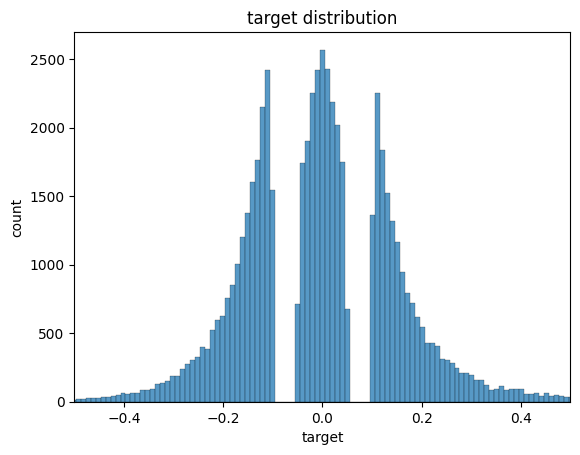

In [8]:
sns.histplot(targets,bins=np.linspace(-1,1,200))
plt.title('target distribution')
plt.xlim(-0.5,0.5)
plt.xlabel('target')
plt.ylabel('count')
plt.show()

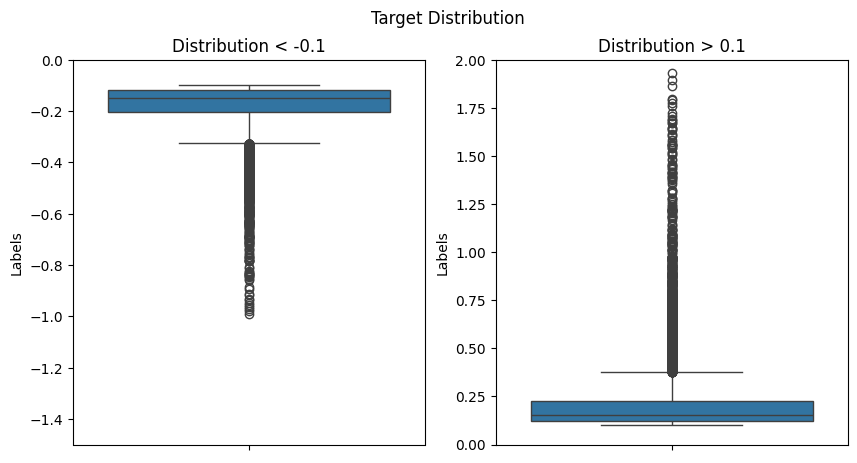

In [9]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.boxplot(y=targets[targets<-0.1].detach().numpy(), ax=ax[0])
sns.boxplot(y=targets[targets>0.1].detach().numpy(), ax=ax[1])

ax[0].set_ylim(-1.5, 0)
ax[1].set_ylim(0, 2)
ax[0].set_title('Distribution < -0.1')
ax[1].set_title('Distribution > 0.1')
ax[0].set_ylabel('Labels')
ax[1].set_ylabel('Labels')
fig.suptitle('Target Distribution')

plt.show()


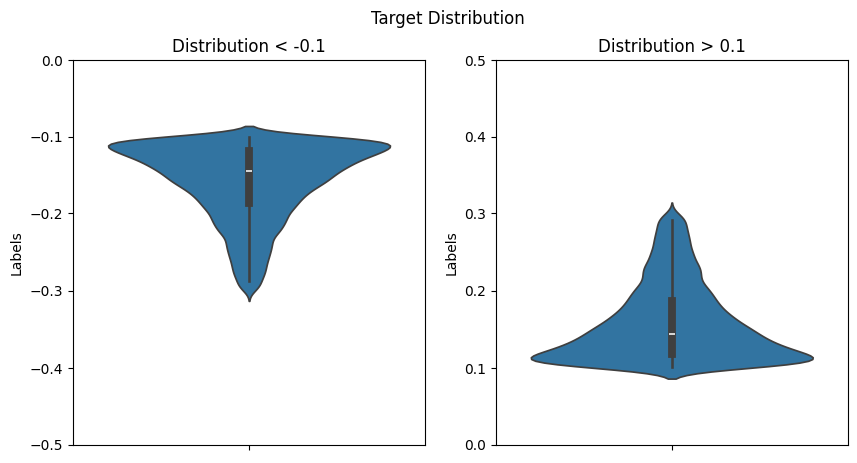

In [10]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.violinplot(y=targets[(targets<-0.1) & (targets>-0.3)].detach().numpy(), ax=ax[0])
sns.violinplot(y=targets[(targets>0.1)  & (targets<0.3)].detach().numpy(), ax=ax[1])

ax[0].set_ylim(-0.5, 0)
ax[1].set_ylim(0, 0.5)
ax[0].set_title('Distribution < -0.1')
ax[1].set_title('Distribution > 0.1')
ax[0].set_ylabel('Labels')
ax[1].set_ylabel('Labels')
fig.suptitle('Target Distribution')

plt.show()


In [11]:
# define outliers
indices_neg = torch.nonzero((targets <= -0.1) & (targets >= -0.3)).squeeze()
indices_pos = torch.nonzero((targets >= 0.1) & (targets <= 0.3)).squeeze()
indices_mid = torch.nonzero((targets >= -0.05) & (targets <= 0.05)).squeeze()
indices_wo_outliers = torch.cat((indices_neg, indices_mid,indices_pos))
print(f'percent of targets after removing outliers: {100*len(indices_wo_outliers)/len(targets)} %')


percent of targets after removing outliers: 93.25503299076934 %


In [12]:
# removing of outliers
images = images[indices_wo_outliers].half()
targets = targets[indices_wo_outliers].half()
print(images.shape)
print(targets.shape)

torch.Size([55262, 2, 106, 106])
torch.Size([55262])


In [10]:
# For binary cross entropy with 2 labels
labels = (targets > 0).float()
labels = labels.unsqueeze(1)
print(labels.shape)

torch.Size([47610, 1])


In [7]:
# For cross entropy with 3 labels
labels = torch.zeros_like(targets).long()
labels[targets >= 0.1] = 2
labels[(targets > -0.1) & (targets < 0.1)] = 1

Counter({3: 10331, 2: 10322, 0: 10096, 1: 10075, 5: 9648, 4: 8787})


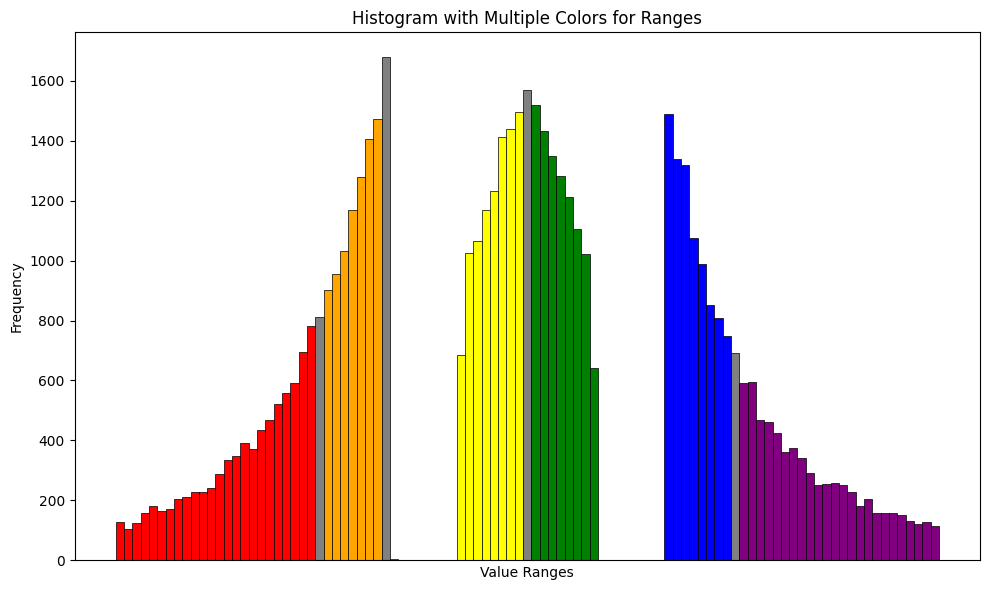

In [34]:
# For cross entropy with 3 labels
from collections import Counter
labels = torch.zeros_like(targets).long()
labels[targets >= 0.15] = 5
labels[(targets < 0.15)&(targets>=0.1)] = 4
labels[(targets < 0.05)&(targets>=0.0)] = 3
labels[(targets < 0.0)&(targets>=-0.05)] = 2
labels[(targets > -0.15)&(targets<=-0.1)] = 1
print(Counter(labels.tolist()))



# Define the edges of the bins
bins = np.linspace(-0.3, 0.3, num=100)  # 100 edges, which creates 99 bins
bin_labels = [f'{bins[i]:.2f} to {bins[i+1]:.2f}' for i in range(len(bins)-1)]  # Create labels for bins

# Create the histogram
plt.figure(figsize=(10, 6))

# Initialize a histogram without drawing
hist = sns.histplot(targets.numpy(), bins=bins, color='lightgray', edgecolor='black', kde=False)

# Get the heights of the bars and the bin edges
counts, edges = np.histogram(targets.numpy(), bins=bins)

# Define colors for specific ranges
color_ranges = {
    'red': (-0.31, -0.15),  # Color for values < -0.15
    'orange': (-0.15, -0.1),  # Color for values between -0.15 and -0.1
    'yellow': (-0.1, 0),  # Color for values between -0.1 and 0
    'green': (0, 0.1),  # Color for values between 0 and 0.1
    'blue': (0.1, 0.15),
    'purple': (0.15, 0.3)   # Color for values between 0.1 and 0.3
}

# Color the bars according to their range
for i in range(len(counts)):
    if counts[i] > 0:  # Only color bins with counts > 0
        # Determine the color for this bin based on the defined ranges
        bin_color = 'gray'  # Start with the default color
        for color, (lower, upper) in color_ranges.items():
            if edges[i] >= lower and edges[i+1] <= upper:
                bin_color = color  # Change to the specific color if it fits the range
                break
        # Set the color for the bar
        hist.patches[i].set_facecolor(bin_color)

# Add labels and title
plt.xticks([],[])  # Use 'ha' for better alignment
plt.xlabel('Value Ranges')
plt.ylabel('Frequency')
plt.title('Histogram with Multiple Colors for Ranges')

# Show the plot
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()



In [51]:
labels = labels.unsqueeze(1).long()
print(labels.shape)
labels.unique()

torch.Size([55262, 1])


tensor([0, 1, 2])

In [50]:
labels = labels.squeeze(-1)
print(labels.shape)

torch.Size([55262])


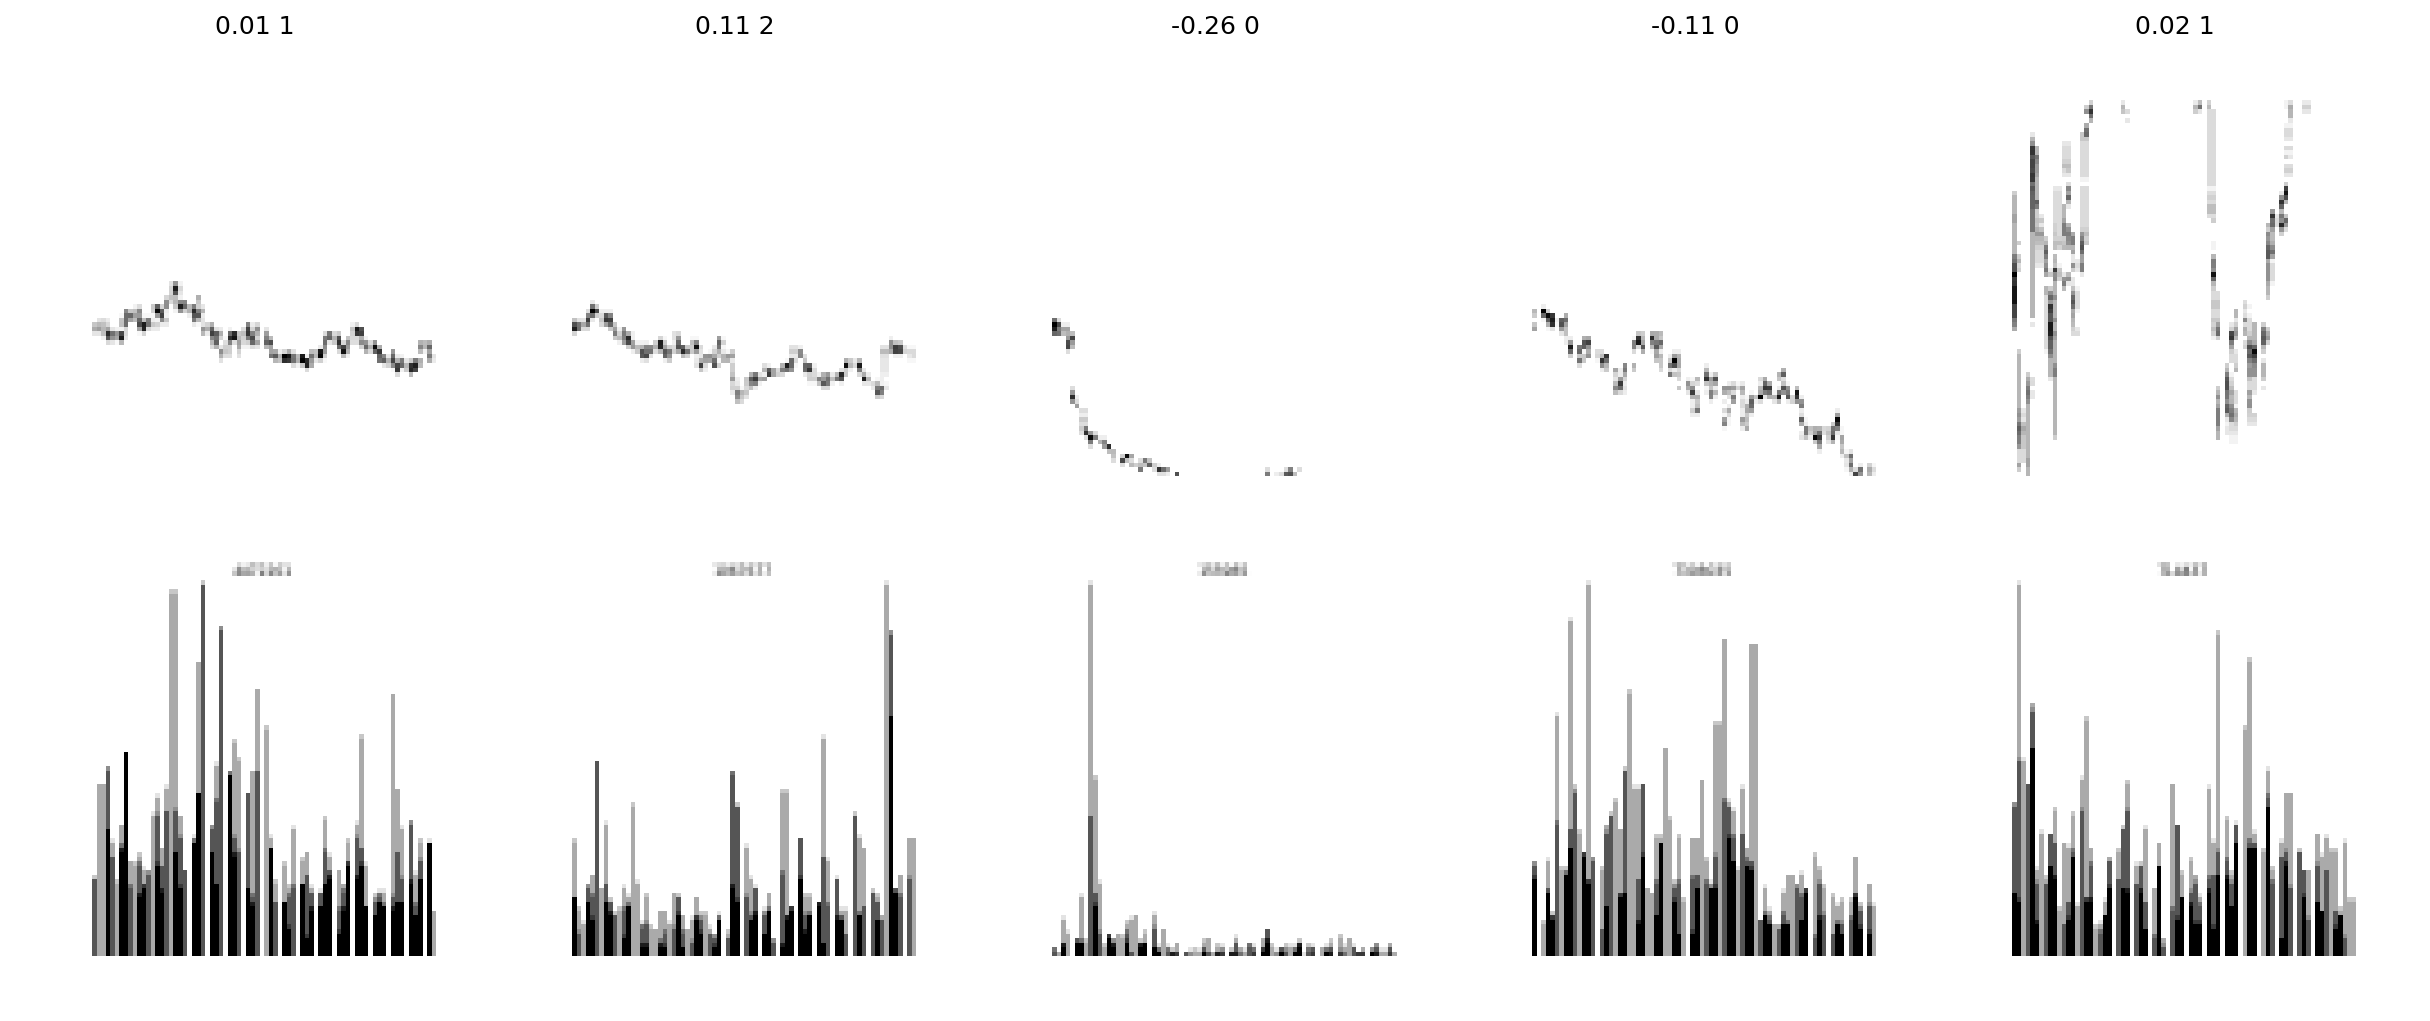

In [38]:
# visualize some images
fig,axs = plt.subplots(2,5,figsize=(5*320/100,2*320/100),dpi=150)

for i in range(axs.shape[1]):

  # pick a random pic
  n = np.random.randint(images.shape[0])

  # visualize
  axs[0,i].imshow(images[n,0,:,:],cmap='gray', aspect='auto')
  axs[1,i].imshow(images[n,1,:,:],cmap='gray', aspect='auto')
  axs[0,i].set_title(f'{round(targets[n].item(),2)} {labels[n].item()}')
  axs[0,i].axis('off')
  axs[1,i].axis('off')

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()

In [51]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.2)
dev_data,test_data, dev_labels,test_labels = train_test_split(test_data, test_labels, test_size=.5)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
dev_data = TensorDataset(dev_data,dev_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 24
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(dev_data,batch_size=batchsize)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [52]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([44209, 2, 106, 106])
torch.Size([44209])


In [11]:
images=[]

In [35]:
# create a class for the model
def XmakeMSENet(printtoggle=False):

  class stockCNN(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
       # Define convolutional layers
      self.conv1 = nn.Conv2d(2, 16, 4, padding=1)
      self.bnorm1 = nn.BatchNorm2d(16, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
# second convolution layer
      self.conv2 = nn.Conv2d(16, 64, 4, padding=1)
      self.bnorm2 = nn.BatchNorm2d(64, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
# third convolution layer
      self.conv3 = nn.Conv2d(64, 256, 4, padding=1)
      self.bnorm3 = nn.BatchNorm2d(256, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
    # output size: (8+2*1-3)/1 + 1 = 14/2 = 4 (/2 b/c maxpool)

      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(36864,256)
      self.fc2 = nn.Linear(256,64)
      self.fc3 = nn.Linear(64,1)

      self.to_half_precision()

    def to_half_precision(self):
        # Convert all parameters to float16 (half precision)
        for param in self.parameters():
            param.data = param.data.half()

        # Convert batch norm buffers (running_mean and running_var) to half precision
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d):
                module.float()


    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Reshaped: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.25,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=.25,training=self.training)
      x = F.tanh(self.fc3(x))
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = stockCNN(printtoggle)

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=0.0001)

  return net,lossfun,optimizer

In [36]:
# create a class for the model
def makeBCENet(printtoggle=False):

  class stockCNN(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(2,16,4,padding=1)
      self.bnorm1 = nn.BatchNorm2d(16) # input the number of channels in this layer
      # output size: (106+2*1-3)/1 + 1 = 32/2 = 16 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(16,64,4,padding=1)
      self.bnorm2 = nn.BatchNorm2d(64) # input the number of channels in this layer
      # output size: (16+2*1-3)/1 + 1 = 16/2 = 8 (/2 b/c maxpool)

            # second convolution layer
      self.conv3  = nn.Conv2d(64,256,4,padding=1)
      self.bnorm3 = nn.BatchNorm2d(256) # input the number of channels in this layer
      # output size: (8+2*1-3)/1 + 1 = 14/2 = 4 (/2 b/c maxpool)

      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(36864,256)
      self.fc2 = nn.Linear(256,64)
      self.fc3 = nn.Linear(64,1)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Reshaped: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.25,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=.25,training=self.training)
      x = self.fc3(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = stockCNN(printtoggle)

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=0.0001)

  return net,lossfun,optimizer

In [37]:
# test the model with one batch
MSEnet,lossfun,optimizer = makeMSENet(True)
# net.half()

X,y = next(iter(train_loader))
yHat = MSEnet(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

# imgSize = images.shape[2]
# summary(MSEnet,(1,imgSize,imgSize))

Input: [24, 2, 106, 106]
First CPR block: [24, 16, 52, 52]
Second CPR block: [24, 64, 25, 25]
Third CPR block: [24, 256, 12, 12]
Reshaped: [24, 36864]
Final output: [24, 1]

Output size:
torch.Size([24, 1])
 
Loss:
tensor(0.0512, dtype=torch.float16, grad_fn=<MseLossBackward0>)


In [11]:
# test the model with one batch
net,lossfun,optimizer = makeBCENet(True)
# net.half()

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

imgSize = images.shape[2]
#summary(net,(1,imgSize,imgSize))

Input: [24, 2, 106, 106]
First CPR block: [24, 16, 52, 52]
Second CPR block: [24, 64, 25, 25]
Second CPR block: [24, 256, 12, 12]
Reshaped: [24, 36864]
Final output: [24, 1]

Output size:
torch.Size([24, 1])
 
Loss:
tensor(0.6954, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [38]:
def Xfunction2trainMSEModel():

    # number of epochs
    numepochs = 10

    # create a new model
    MSEnet, lossfun, optimizer = makeMSENet(False)

    # send the model to the GPU
    MSEnet.to(device).half()

    # Initialize the scaler for AMP
    scaler = GradScaler()

    # initialize losses
    trainLoss = []
    devLoss = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):
        print(epochi)

        # loop over training data batches
        MSEnet.train()
        batchLoss = []

        for X, y in train_loader:
            # push data to GPU
            X = X.to(device).half()
            y = y.to(device).half()

            # forward pass and loss with AMP
            with autocast():  # Enable mixed precision
                yHat = MSEnet(X)
                loss = lossfun(yHat, y)

            # backprop with AMP
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # store loss
            batchLoss.append(loss.item())

        # store training loss
        trainLoss += batchLoss

        ### Test performance
        MSEnet.eval()
        X, y = next(iter(dev_loader))  # extract X, y from test dataloader

        # push data to GPU
        X = X.to(device).half()
        y = y.to(device).half()

        with torch.no_grad(), autocast():
            yHat = MSEnet(X)
            loss = lossfun(yHat, y)

        # extract the loss for this test epoch
        devLoss[epochi] = loss.item()

    # return losses and trained model
    return trainLoss, devLoss, MSEnet


In [39]:
import torch.cuda.amp as amp
from torch.cuda.amp import autocast, GradScaler
# a function that trains the model

def Xfunction2trainMSEModel():

  # number of epochs
  numepochs = 10

  # create a new model
  MSEnet,lossfun,optimizer = makeMSENet(False)

  # send the model to the GPU
  MSEnet.to(device).half()

  # Initialize the scaler for AMP
  scaler = GradScaler()

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  trainLoss = []
  devLoss  = torch.zeros(numepochs)
  # trainErr  = torch.zeros(numepochs)
  # devErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):
    print(epochi)
    # loop over training data batches
    MSEnet.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device).half()
      y = y.to(device).half()

      # forward pass and loss with AMP
      with autocast():  # Enable mixed precision
          yHat = MSEnet(X)
          loss = lossfun(yHat, y)

      # backprop with AMP
      optimizer.zero_grad()
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()

      # # forward pass and loss
      # yHat = MSEnet(X)
      # loss = lossfun(yHat,y)

      # # backprop
      # optimizer.zero_grad()
      # loss.backward()
      # optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())

    # end of batch loop...

    # and get average losses and error rates across the batches
    #trainLoss[epochi] = np.mean(batchLoss)
    trainLoss+=batchLoss
    # trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    MSEnet.eval()
    X,y = next(iter(dev_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device).half()
    y = y.to(device).half()
    with torch.no_grad(), autocast(): # deactivates autograd
      #with amp.autocast():  # Enable mixed precision
      yHat = MSEnet(X)
      loss = lossfun(yHat,y)

    # extract the loss for this test epoch
    devLoss[epochi] = loss.item()

  # end epochs

  # function output
  return trainLoss,devLoss,MSEnet

In [40]:
# a function that trains the model

def function2trainBCEModel():

  # number of epochs
  numepochs = 3

  # create a new model
  net,lossfun,optimizer = makeBCENet(False)

  # send the model to the GPU
  net.to(device)

  # initialize losses
  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc   = torch.zeros(numepochs)
  # trainErr  = torch.zeros(numepochs)
  # devErr   = torch.zeros(numepochs)
  batchLoss = []
  batchAcc  = []

  # loop over epochs
  for epochi in range(numepochs):
    print(epochi)
    # loop over training data batches
    net.train()

    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>0) ==y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    ### test performance
    net.eval()
    X,y = next(iter(dev_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # extract the loss for this test epoch
    devLoss[epochi] = loss.item()
    devAcc[epochi]  = 100*torch.mean(( (yHat>0) ==y).float()).item()

  # end epochs

  # function output
  return trainLoss,devLoss,trainAcc,devAcc,net,batchLoss,batchAcc

In [9]:
def makeMSENet(printtoggle=False):
    class stockCNN(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()
            self.print = printtoggle

            # Convolutional layers
            self.conv1 = nn.Conv2d(2, 16, 4, padding=1)
            self.bnorm1 = nn.BatchNorm2d(16)
            self.conv2 = nn.Conv2d(16, 64, 4, padding=1)
            self.bnorm2 = nn.BatchNorm2d(64)
            self.conv3 = nn.Conv2d(64, 256, 4, padding=1)
            self.bnorm3 = nn.BatchNorm2d(256)

            # Linear layers
            self.fc1 = nn.Linear(36864, 256)
            self.fc2 = nn.Linear(256, 64)
            self.fc3 = nn.Linear(64, 1)

        def forward(self, x):
            if self.print: print(f'Input: {list(x.shape)}')

            # First block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv1(x), 2)
            x = F.leaky_relu(self.bnorm1(x))
            x = F.dropout(x, p=.1, training=self.training)

            # Second block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu(self.bnorm2(x))
            x = F.dropout(x, p=.1, training=self.training)

            # Third block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv3(x), 2)
            x = F.leaky_relu(self.bnorm3(x))
            x = F.dropout(x, p=.1, training=self.training)

            # Reshape for linear layer
            x = x.view(x.size(0), -1)

            # Linear layers
            x = F.leaky_relu(self.fc1(x))
            x = F.dropout(x, p=.25, training=self.training)
            x = F.leaky_relu(self.fc2(x))
            x = F.dropout(x, p=.25, training=self.training)
            x = torch.tanh(self.fc3(x))

            if self.print: print(f'Final output: {list(x.shape)}')

            return x

    # Create the model instance
    net = stockCNN(printtoggle)

    # Loss function
    lossfun = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=0.0001)

    return net, lossfun, optimizer





In [15]:
def function2trainMSEModel():
    # Number of epochs
    numepochs = 5

    # Create a new model
    MSEnet, lossfun, optimizer = makeMSENet(False)

    # Send the model to the GPU
    MSEnet.to(device)

    # Initialize the scaler for AMP
    scaler = GradScaler()

    # Initialize losses
    trainLoss = []
    devLoss = torch.zeros(numepochs)

    # Loop over epochs
    for epochi in range(numepochs):
        print(f'Epoch {epochi + 1}/{numepochs}')

        # Loop over training data batches
        MSEnet.train()
        batchLoss = []

        for X, y in train_loader:
            # Push data to GPU (convert to half here)
            X = X.to(device).half()
            y = y.to(device).half()

            # Check for NaN in inputs
            if torch.isnan(X).any() or torch.isnan(y).any():
                print("Warning: Found NaN values in input data.")
                continue  # Skip this batch if NaNs are found

            # Forward pass and loss with AMP
            with autocast():  # Enable mixed precision
                yHat = MSEnet(X)
                loss = lossfun(yHat, y)

            # Check for NaN in loss
            if torch.isnan(loss).any() or torch.isinf(loss).any():
                print(f"Warning: Loss is NaN or Inf: {loss.item()}")
                continue  # Skip this batch if loss is invalid

            # Backprop with AMP
            optimizer.zero_grad()
            scaler.scale(loss).backward()

            # After scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(MSEnet.parameters(), max_norm=1.0)

            # Check gradients before unscale
            for param in MSEnet.parameters():
                if param.grad is not None and (torch.isinf(param.grad).any() or torch.isnan(param.grad).any()):
                    print("Warning: Found inf/nan gradients before optimizer step.")
                    continue  # Skip the optimizer step if gradients are invalid

            # Step the optimizer
            scaler.step(optimizer)
            scaler.update()

            # Store loss
            batchLoss.append(loss.item())

        # Store training loss
        trainLoss += batchLoss

        # Test performance
        MSEnet.eval()
        X, y = next(iter(dev_loader))  # Extract X, y from test dataloader

        # Push data to GPU
        X = X.to(device).half()
        y = y.to(device).half()

        with torch.no_grad(), autocast():
            yHat = MSEnet(X)
            loss = lossfun(yHat, y)

        # Extract the loss for this test epoch
        devLoss[epochi] = loss.item()

    # Return losses and trained model
    return trainLoss, devLoss, MSEnet,lossfun


In [37]:
def function2trainCEModel(numepochs):

    # Create a new model
    CEnet, lossfun, optimizer = makeCENet(False)

    # Send the model to the GPU (do not convert to half)
    CEnet.to(device)
    # Do NOT use CEnet.half()

    # Initialize the scaler for AMP
    scaler = GradScaler()

    # Initialize losses
    trainLoss = torch.zeros(numepochs)
    devLoss = torch.zeros(numepochs)
    trainErr = torch.zeros(numepochs)
    devErr = torch.zeros(numepochs)
    batchLoss = []
    batchErr = []
    # Loop over epochs
    for epochi in range(numepochs):
        print(f'Epoch {epochi + 1}/{numepochs}')

        # Loop over training data batches
        CEnet.train()

        for X, y in train_loader:

            # Push data to GPU (do not convert to half)
            X = X.to(device)
            y = y.to(device).long()  # CrossEntropyLoss requires Long targets

            # Forward pass and loss with AMP
            with autocast():  # Enable mixed precision
                yHat = CEnet(X)
                loss = lossfun(yHat, y)

            # Check for NaN in loss
            if torch.isnan(loss).any() or torch.isinf(loss).any():
                print(f"Warning: Loss is NaN or Inf: {loss.item()}")
                continue  # Skip this batch if loss is invalid

            # Backprop with AMP
            optimizer.zero_grad()
            scaler.scale(loss).backward()

            # Unscale gradients before clipping
            scaler.unscale_(optimizer)

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(CEnet.parameters(), max_norm=1.0)

            # Step the optimizer
            scaler.step(optimizer)
            scaler.update()

            # Store loss
            batchLoss.append(loss.item())
            batchErr.append(100*torch.mean((torch.argmax(yHat, axis=1) != y).float()).item())

        # Store training loss and error
        trainLoss[epochi] = np.mean(batchLoss)
        trainErr[epochi] = np.mean(batchErr)

        # Validation performance
        CEnet.eval()
        X, y = next(iter(dev_loader))

        # Push data to GPU
        X = X.to(device)
        y = y.to(device).long()

        with torch.no_grad(), autocast():
            yHat = CEnet(X)
            loss = lossfun(yHat, y)

        # Store validation loss and error
        devLoss[epochi] = loss.item()
        devErr[epochi] = 100 * torch.mean((torch.argmax(yHat, axis=1) != y).float()).item()

    # Return losses and trained model
    return trainLoss, devLoss, trainErr, devErr, CEnet, lossfun,batchLoss,batchErr


In [41]:
# create a class for the model
def makeCENet(printtoggle=False):

  class stocknet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      # Convolutional layers
      self.conv1 = nn.Conv2d(2, 16, 4, padding=1)
      self.bnorm1 = nn.BatchNorm2d(16)
      self.conv2 = nn.Conv2d(16, 64, 4, padding=1)
      self.bnorm2 = nn.BatchNorm2d(64)
      self.conv3 = nn.Conv2d(64, 256, 4, padding=1)
      self.bnorm3 = nn.BatchNorm2d(256)

      # Linear layers
      self.fc1 = nn.Linear(36864, 256)
      self.fc2 = nn.Linear(256, 64)
      self.fc3 = nn.Linear(64, 3)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Reshaped: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.25,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=.25,training=self.training)
      x = self.fc3(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = stocknet(printtoggle)

  # loss function
  class_weights = torch.tensor([1/0.15, 1/0.68, 1/0.17], dtype=torch.half)  # Adjust as needed
  lossfun = nn.CrossEntropyLoss(weight=class_weights)
  # lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=0.001)

  return net,lossfun,optimizer

In [26]:
# a function that trains the model

def function2trainCEModelCPU(numepochs):


  # create a new model
  net,lossfun,optimizer = makeCENetCPU()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  devErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):
    print(f'Epoch {epochi + 1}/{numepochs}')

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:
      print(f'X shape: {X.shape}, y shape: {y.shape}')
      # push data to GPU
      X = X.to(device)
      y = y.to(device)
      print(f'Unique values in y: {y.unique()}')
      # forward pass and loss
      yHat = net(X)
      print(f'yHat shape: {yHat.shape}, y shape: {y.shape}')
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(dev_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # get loss and error rate from the test batch
    devLoss[epochi] = loss.item()
    devErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs

  # function output
  return trainLoss,devLoss,trainErr,devErr,net

In [57]:

def validate_data(loader):
    for X, y in loader:
        if torch.isnan(X).any() or torch.isnan(y).any():
            print("Warning: NaN detected in training data.")
            return False
    return True

# Call this function before training
if not validate_data(train_loader):
    print("Training data contains NaNs.")

In [57]:
device = torch.device('cpu')

In [60]:
validate_data(test_loader)

True

In [15]:
trainLoss,devLoss,MSEnet,lossfun = function2trainMSEModel()

NameError: name 'function2trainMSEModel' is not defined

In [42]:
numepochs = 20
trainLoss,devLoss,trainErr,devErr,CEnet,CElossfun,batchLoss,batchErr = function2trainCEModel(numepochs)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [16]:
trainLoss,testLoss,trainAcc,testAcc,BCEnet,batchLoss,batchAcc = function2trainBCEModel()

0
1
2


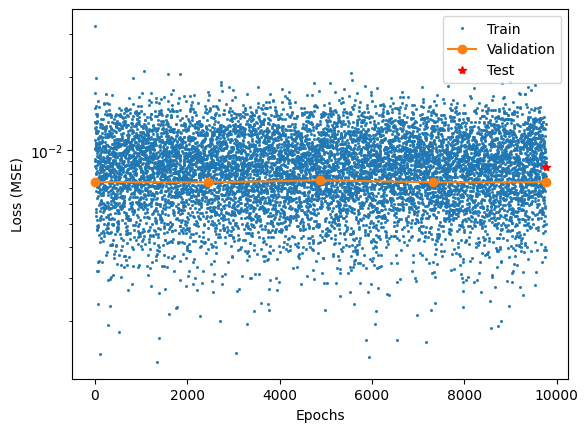

In [18]:
X,y = next(iter(test_loader))
X = X.to(device).half() # push data to GPU
y = y.to(device).half() # push data to GPU
with torch.no_grad(), autocast():
    yHat = MSEnet(X)
    test_loss = lossfun(yHat, y)
# yHat = MSEnet(X)
# test_loss = round(F.mse_loss(yHat,y),4)
# print(f'Test Loss : {test_loss:.4f}')
numepochs =5
plt.plot(trainLoss,'s',label='Train',markersize=1)
plt.plot(np.linspace(0,len(trainLoss),numepochs),devLoss,'o-',label='Validation')
plt.plot(np.linspace(0,len(trainLoss),numepochs)[-1],test_loss.cpu(),'r*',label='Test')
# plt.ylim((0,1))
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')

plt.legend()
# plt.title('Model loss (final test loss: %.2f)'%testLoss[-1])

plt.show()

NameError: name 'batchLoss' is not defined

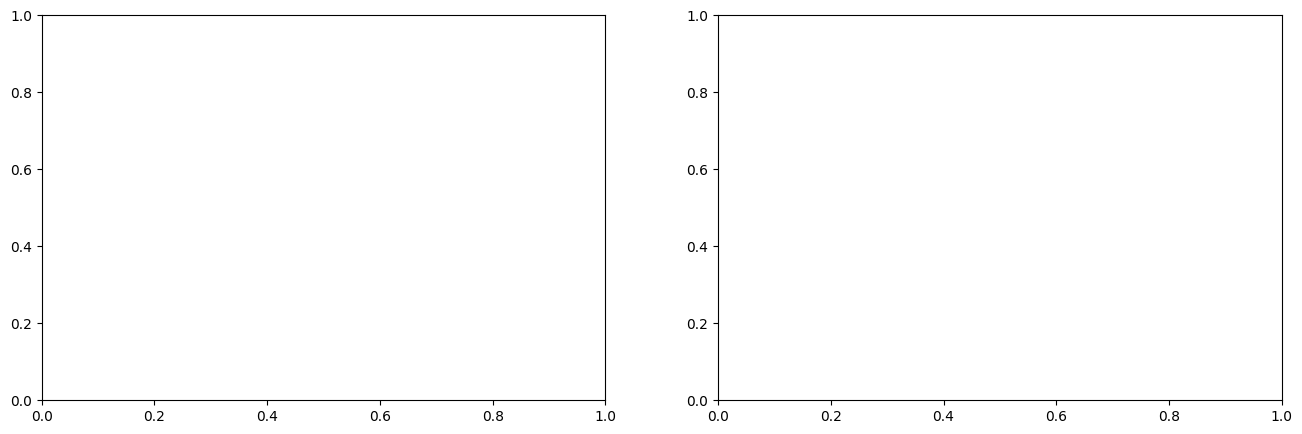

In [20]:
numepochs=5
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(np.linspace(0,len(batchLoss),numepochs),trainLoss,'s-',label='Train')
ax[0].plot(np.linspace(0,len(batchLoss),numepochs),testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[0].plot(batchLoss,'-',label='Batch')

ax[1].plot(batchAcc,'s-',label='Batch')

ax[1].plot(np.linspace(0,len(batchAcc),numepochs),trainAcc,'s-',label='Train')
ax[1].plot(np.linspace(0,len(batchAcc),numepochs),testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
X,y = next(iter(test_loader))
X = X.to(device) # push data to GPU
y = y.to(device) # push data to GPU
yHat = net(X)
test_acc = round(100*torch.mean(( (yHat>0) ==y).float()).item(),4)
print(f'Test Loss : {test_acc:.4f}')

In [30]:
torch.save(net.state_dict(), savePath+'BCEnet_3epochs_2000stocks-28Sept2024.pth')


RuntimeError: a Tensor with 3 elements cannot be converted to Scalar

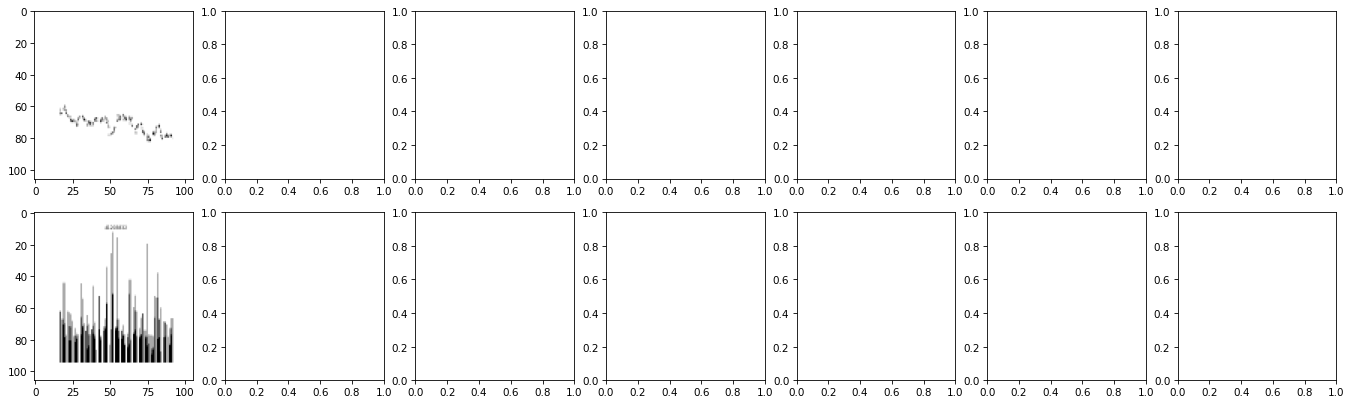

In [35]:


# visualize some images
fig,axs = plt.subplots(2,7,figsize=(7*320/100,2*320/100),dpi=75)

for i in range(axs.shape[1]):

  # pick a random pic
  n = np.random.randint(X.cpu().shape[0])

  # visualize
  axs[0,i].imshow(torch.squeeze( X.cpu()[n,0,:,:] ).detach(),cmap='gray', aspect='auto')
  axs[1,i].imshow(torch.squeeze( X.cpu()[n,1,:,:] ).detach(),cmap='gray', aspect='auto')
  axs[0,i].set_title(f't={round(y.cpu()[n].item(),2)} p={round(yHat.cpu()[n].item(),2)}')
  axs[0,i].axis('off')
  axs[1,i].axis('off')

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()

Test Error : 19.49%


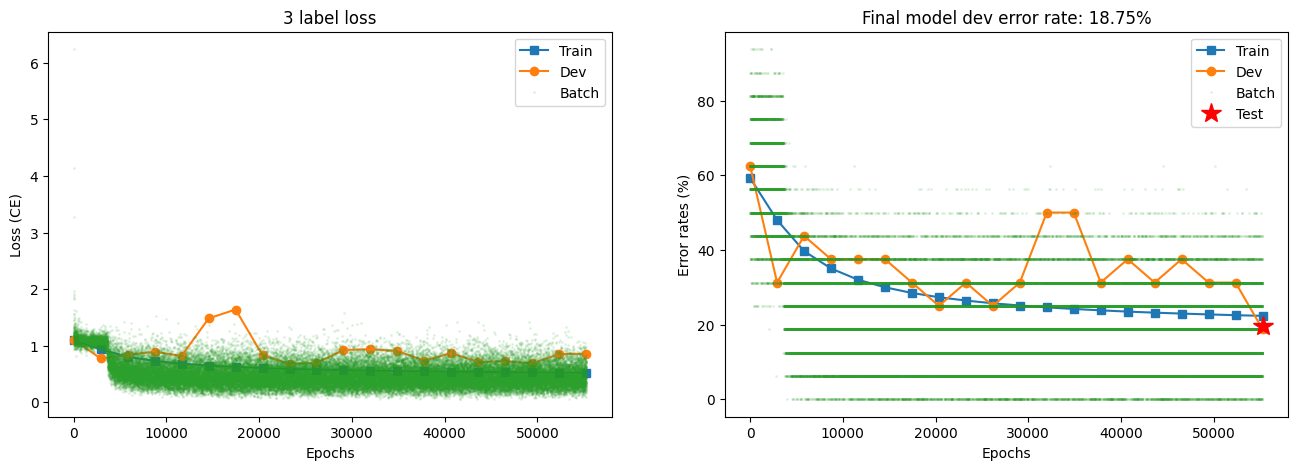

In [49]:
X,y = next(iter(test_loader))
X = X.to(device).half() # push data to GPU
y = y.to(device).long() # push data to GPU
with torch.no_grad(), autocast():
    yHat = CEnet(X)
    test_loss = CElossfun(yHat, y)
testErr = 100*torch.mean((torch.argmax(yHat.cpu(),axis=1) != y.cpu()).float()).item()
print(f'Test Error : {testErr:.2f}%')


fig,ax = plt.subplots(1,2,figsize=(16,5))
xaxispoints = np.linspace(0,len(batchLoss),numepochs)
ax[0].plot(xaxispoints,trainLoss,'s-',label='Train')
ax[0].plot(xaxispoints,devLoss,'o-',label='Dev')
ax[0].plot(batchLoss,'s',label='Batch',markersize=1,alpha=0.1)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CE)')
ax[0].set_title('3 label loss')
ax[0].legend()


ax[1].plot(xaxispoints,trainErr,'s-',label='Train')
ax[1].plot(xaxispoints,devErr,'o-',label='Dev')
ax[1].plot(batchErr,'s',label='Batch',markersize=1,alpha=0.1)
ax[1].plot(len(batchLoss),testErr,'*',label='Test',markersize=15, color='r')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model dev error rate: {devErr[-1]:.2f}%')
ax[1].legend()

plt.show()

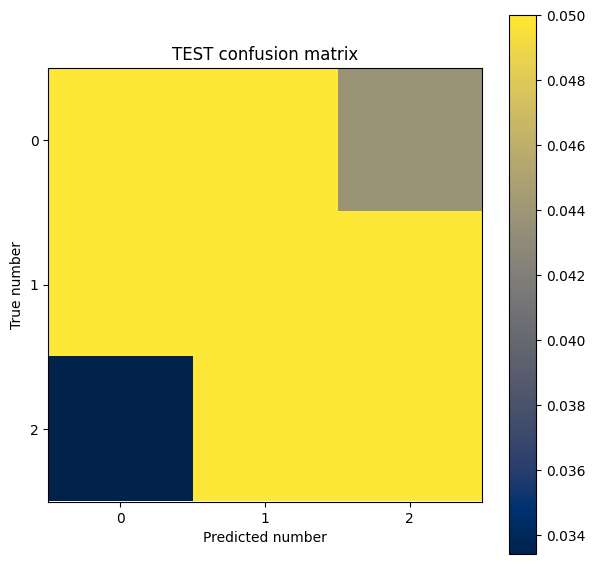

In [50]:
import sklearn.metrics as skm

# compute the confusion matrix
C = skm.confusion_matrix(y.cpu(),torch.argmax(yHat.cpu(),axis=1),normalize='true')

# visualize it
fig = plt.figure(figsize=(7,7))
plt.imshow(C,'cividis',vmax=.05)

# make the plot look nicer
plt.xticks(range(3))
plt.yticks(range(3))
plt.title('TEST confusion matrix')
plt.xlabel('True number')
plt.xlabel('Predicted number')
plt.ylabel('True number')
plt.colorbar()

plt.show()

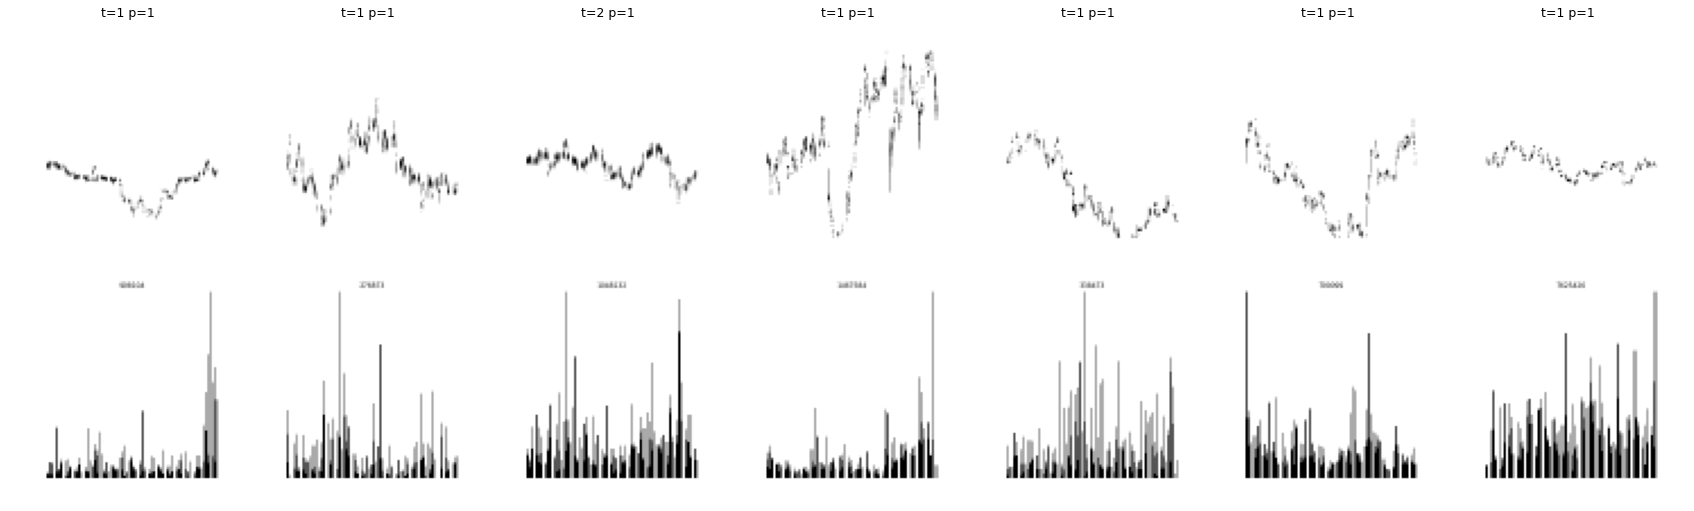

In [25]:
# visualize some images
fig,axs = plt.subplots(2,7,figsize=(7*320/100,2*320/100),dpi=75)
i=0
while i != 7:
  #  i in range(axs.shape[1]):

  # pick a random pic
  n = np.random.randint(X.cpu().shape[0])
  if y.cpu()[n] !=0:
    # visualize
    axs[0,i].imshow(torch.squeeze( X.cpu()[n,0,:,:] ).detach(),cmap='gray', aspect='auto')
    axs[1,i].imshow(torch.squeeze( X.cpu()[n,1,:,:] ).detach(),cmap='gray', aspect='auto')
    axs[0,i].set_title(f't={round(y.cpu()[n].item(),2)} p={torch.argmax(yHat.cpu()[n])}')
    axs[0,i].axis('off')
    axs[1,i].axis('off')
    i+=1
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()

In [43]:
sum(y==1)

tensor(0, device='cuda:0')

In [ ]:
# how much does it add in volume and time to increase img size?
# add noise?